# **Dunnhumby, The Complete Journey Analysis:**

## **INTRODUCTION:**
The Dunnhumby Dataset consists of anonymized shopping data from 2,500 households and spanning over two years. The data is well formatted and requires very little processing. It contains generic information about the household and its composition, as well as consumption information in groceries, broad description of the products, and details about the potential discounts coupons that were redeemed. <br>
In this analysis, we focus mainly on food products since we want to establish a link with openfoodfacts dataset. We hence use only three files of Dunnhumby : hh_demographic.csv, product.csv, transaction_data.csv. <br>
We start studying each feature's statistics in order to identify the most relevant and important ones. Then we merge the three files in order to have one dataframe containing all the significant features. Then we analyse the correlations between attributes of the dataset in order to find potential links. <br>

**For easier readability:** <br>
- The notebook is divided into parts each one focusing on a part of the analysis
- Comments explain what has been done in the **next** cells up until the following comment. They are in italic.
- 

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import seaborn as sns

In [2]:
def plotDistributionDataset(df):
    n_row, n_col = df.shape
    columns = list(df.columns)
    plt.figure(num = None, figsize = (5*3,5*np.ceil(n_col/3)))
    for i in range(n_col):
        plt.subplot(int(np.ceil(n_col/3)),3,i+1)
        subdf = df.iloc[:,i]
        if (not np.issubdtype(type(subdf.iloc[0]), np.number)):
            valueCounts = subdf.value_counts()
            valueCounts.sort_index(ascending=True).plot.bar()
        else:
            if(subdf.dtype == 'int64'):
                subdf.hist(bins = subdf.max()-subdf.min())
            else :
                subdf.hist()
                
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columns[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [3]:
def correct_indecome(x):
    if(x == "Under 15K"):
        c = "-15K"
    elif(len(x) == 6):
        c = '-'.join([x.split('-')[0].zfill(3),x.split('-')[1].zfill(4)])
    else:
        c = x
    return c

In [4]:
def correct_marital_status(x):
    if(x == "A"):
        c = "Married"
    elif(x == "B"):
        c = "Single"
    elif(x == "U"):
        c = "Unknown"
    return c

In [5]:
def replace_unknowns(hh_comp, marital_status, hh_size):
    if(hh_comp == '2 Adults Kids' and marital_status == 'Unknown'):
        marital_status = 'Married'
    elif(hh_comp == '1 Adult Kids' and marital_status == 'Unknown'):
        marital_status = 'Single' 
    elif((hh_comp == 'Single Male' or hh_comp == 'Single Female') and marital_status == 'Unknown'):
        marital_status = 'Single' 
    elif(hh_size == '1' and marital_status == 'Unknown'):
        marital_status = 'Single' 
    else:
        marital_status = marital_status
    return marital_status

## **A. Feature Analysis:**

In this part, we load the three subdatasets we decided to use and conduct some preliminary study on each one of them.

#### **A1. Demographic Analysis:**

_**Comments:** <br>
The hh_demographic subdataset contains demographic information on 801 households. For each one, it offers the age range, the marital status, the income range, type of ownership, household composition, size, and number of kids. This dataset is not complete since the Dunnhumby study was done on 2500 households, while there is demographic information on 801 only._

In [6]:
demographic = pd.read_csv('data/Dunhumby/hh_demographic.csv', delimiter=',')
print(f'The number of rows and columns in the dataframe is respectively {demographic.shape[0]} and {demographic.shape[1]}')
demographic.head()

The number of rows and columns in the dataframe is respectively 801 and 8


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


_**Comments:** <br>
We can see that for the demgraphic subdataset, there is no NaN values so there is no cleaning to do on this part._

In [7]:
demographic.isna().all()

AGE_DESC               False
MARITAL_STATUS_CODE    False
INCOME_DESC            False
HOMEOWNER_DESC         False
HH_COMP_DESC           False
HOUSEHOLD_SIZE_DESC    False
KID_CATEGORY_DESC      False
household_key          False
dtype: bool

_**Comments:**<br>
For better visualization in the plots below, we preprocess the class names for the Income feature in order to have an ascending order._

In [8]:
demographic.INCOME_DESC = demographic.INCOME_DESC.apply(correct_indecome)
demographic.MARITAL_STATUS_CODE = demographic.MARITAL_STATUS_CODE.apply(correct_marital_status)

_**Comments:** <br>
We use our custom made function in order to plot the distributions of each feature of the demographic dataset._
- _`AGE` : The age feature is composed of 6 classes ranging from 19 years old to +65. The most commonn class (the one with the maximum value counts) is '45-54', with a value count of 288. It is also easily noticeable that the distribution between classes is not uniform._
- _`Marital Status` : This feature is composed of 3 classes: Married, Single and Unknown. The most commonn classes are 'Married' and 'Unknown' , with a value count of 340 and 344, respectively (The Unknown values will addressed later). For this feature also, the distribution is not uniform between classes._ <br>
- _`Income` : Composed of 12 classes, this feature ranges from an income of under of 15K US dollars to +250k. The most commun class is '50-74K', with a value count of 192.For this feature also, the distribution is not uniform between classes._<br>
- _`Homeowner`: This one specifies the type of ownership of the household. Meaning if the individuals living in this house are homeowners or renters. It is composed of 5 classes: 'Homeowner', 'Probable Owner', 'Probable Renter', 'Renter' an 'Unknown'. The most commor type of ownership is 'Homeowner._<br>
- _`Household composition` : This feature contains 6 classes detailing the composition of housholds. The most common class is '2 adults no kids'. Since this feature contains much less 'Unknown' values then `Marital Status`, and could provide information about this latter, we intend to use this feature to complete the missing values of marital status._<br>
- _`Household Size`: This feature give the number of individuals per houshold. It is composed of 5 classes ranging from 1 to +5 individuals. This attribute can also be used as an indicator for completing the marital status feature._<br>
- _`Kid Category`: This attribute is the number of kids per household. It has 4 classes, '1' kid, '2' kids, '+3' kids as well as 'Unknown'. This latter is the most common one._<br>
- _`Household Key` : we notice that the dataset contains demographic information for a portion of households, meaning that the demogrphic is not available for all households._<br>


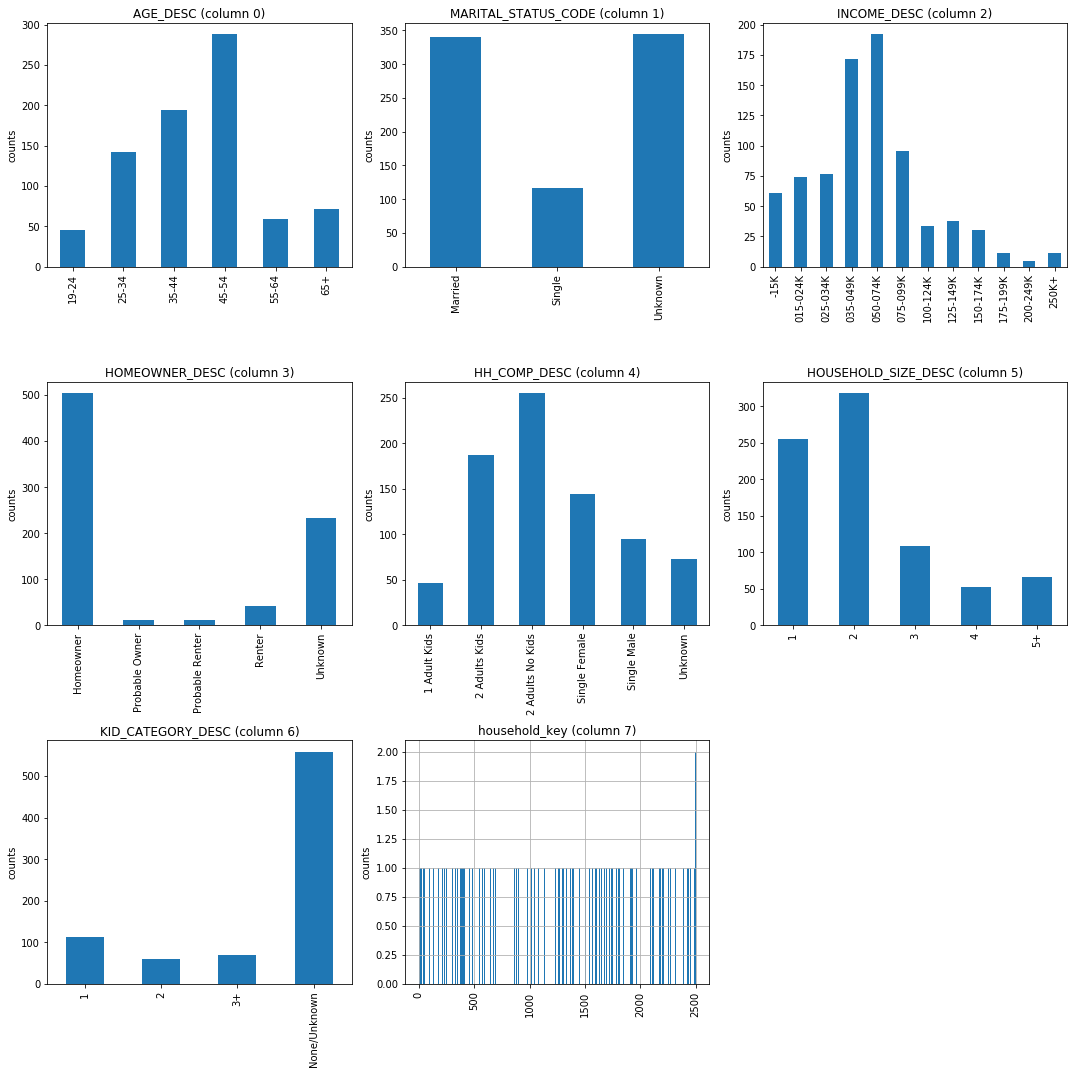

In [9]:
plotDistributionDataset(demographic)

_**Comments:**
As we said previously, we use `Household Composition` and `Household Size` to replace the unknown values of `Marital Status`. Indeed, since these information are conceptually linked, we could infer from one the value of the other. We implemented a rule based function called `replace_unknowns()` that assigns a class to the marital status depending on the values of household composition and size. We consider 2 adults with kids as married, 1 adult with kids as single, single male/female as single, and if size is 1 we also assign single.<br>
We can see that have been able to reduce the number of Uknown values from 344 to 95. We won't drop the remaining Unknowns  since we intend to use mainly income, age and composition information, and we don't want to lose that rows._

In [10]:
demographic.MARITAL_STATUS_CODE = demographic.apply(lambda row: replace_unknowns(row['HH_COMP_DESC'],
                                                    row['MARITAL_STATUS_CODE'], row['HOUSEHOLD_SIZE_DESC']),axis=1)

In [11]:
demographic.MARITAL_STATUS_CODE.value_counts()

Married    383
Single     323
Unknown     95
Name: MARITAL_STATUS_CODE, dtype: int64

_**Comments:**<br>
Now we try to take a look at the dependancy between our features. We start by one hot encoding our features since they are categorical.Then plot a correlation heatmap to compare features. We observe the following:_
- _There is a relatively high correlation between marital status and the household size, which is expectable since mainly married couples would have a household size of more than 2. We also observe that households labeled single tend to have a size of 1._
- _There is a high correlation between marital status and homeownership status. We can see that married couples tend to possess the ownership of their house, while singles are mostly renters or with unknow ownership status._
- _Marital status shows also some correlation with the income. Married couples tend to have a high income ranging from 75K to +250K, while singles tend to have a lower income ranging from under 15K to 34K._
- _We could also observe a slight correlation between the age feature and the income. Household with le lowest age range 19-24 yo seem to be the ones with the highest income +250K but also with the lowest one under 15K. While the other classes of age up until 64 yo seem to have an income ranging between 50K and 199K. A higher age seems to be correlated with a lower income of 35K-49K._

In [12]:
one_hot_demographic = pd.get_dummies(demographic, columns=['AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC', 
                                                           'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC'])

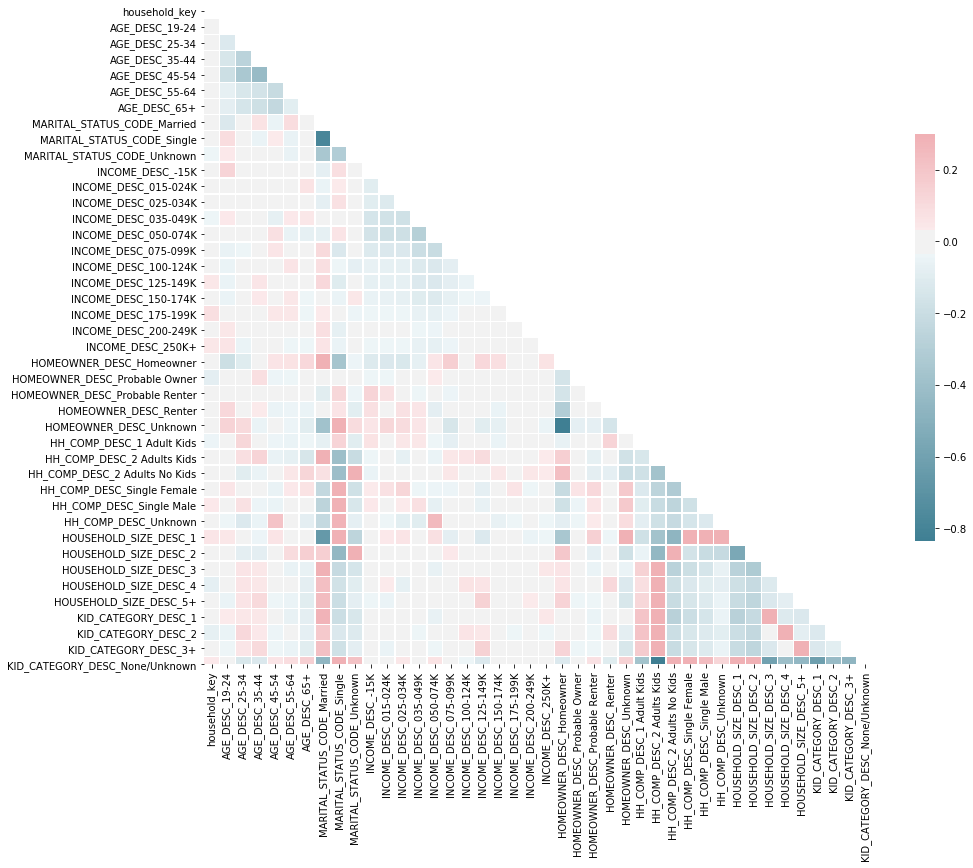

In [31]:
corr = one_hot_demographic.corr(method = 'pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

#### **A2. Transactions Analysis:**

_**Comments:** <br>
The transaction data subdataset contains all the purchases made by households within the study.This table is transaction centered, it essentially provides for each transaction the ID of the household which bought it, the product ID, the quantity bought, the sales value which is the margin gained by the retailer, as well as the transaction time, day and week._

In [14]:
transaction = pd.read_csv('data/Dunhumby/transaction_data.csv', delimiter=',')
print(f'The number of rows and columns in the dataframe is respectively {transaction.shape[0]} and {transaction.shape[1]}')
transaction.head()

The number of rows and columns in the dataframe is respectively 2595732 and 12


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


_**Comments:**<br>
Since we saw in the demographic analysis that the first subdataset doesn't include all the household IDs. It is pertinant to keep the transactions made by households with provided demographic data only, thus the following._

In [15]:
demographic_households = demographic.household_key.unique()
transaction = transaction[transaction.household_key.apply(lambda x: x in demographic_households)]
print(f'The number of rows and columns in the dataframe now is now respectively {transaction.shape[0]} and {transaction.shape[1]}')

The number of rows and columns in the dataframe now is now respectively 1427303 and 12


_**Comments:**<br>
This dataset details all the transactions made by each household. Therefore, it gives information on their consumption over time. Using the custom function to plot the distributions of each feature, we get the following plots and observations:_
- _`Week_no` : This feature specifies the week during which the transaction has been made. It ranges from 0 to 102. We can see that the consumption starts low in the first weeks, and increases rapidly to reach a trend plateau of approcimately 28000 transactions per week. Also we notice that in the last week, consumption explodes to nearly 50000 transctions. To keep the data uniform and have a fixed consumption over the weeks, we intend to drop the transactions made during the first and last weeks._
- _`Transaction Time` : This feature provides the time during the day at which the transaction has been made. It ranges from 0 to 2400, corresponding to the 24 hours of the day. We can see that most of the transactions are made during the day between 10:00 and 22:00, with a maximum of consumption at 18:00._
- _`Day`: This feature specifies in which day the transaction has been made. It just gives a more precise date than the week_no attribute. As in this latter, we can see that there is a low consumption during the first days increasing to reach a plateau of approximately 4000 transactions per day. Since this feature represents a higher time resolution, we will drop the transactions made in the first and last few days to make the data more uniform over time._
_The custom function does not give correct plots for the features `QUANTITY` and `SALES_VALUE`, because the distributions of these attributes are extremely skewed, this is why we plot them separatly. We obseve the following:_
- _`Quantity` : This feature gives the quantity of the product bought at each transaction. It is heavy tailed with value that reach more than 89000. However most of the values are between 0 and 10._ 
- _`Sales value` : This attribute reprensents the margin gained by the retailer in the transaction. The price of the product could be derived from this value, which we'll do later. It is also highly skewed but most values range between 0 and 20._

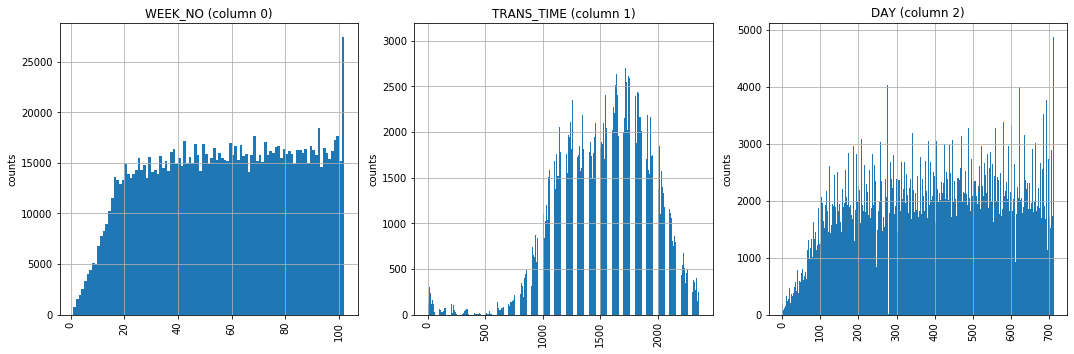

In [16]:
plotDistributionDataset(transaction.loc[:,['WEEK_NO','TRANS_TIME','DAY']])

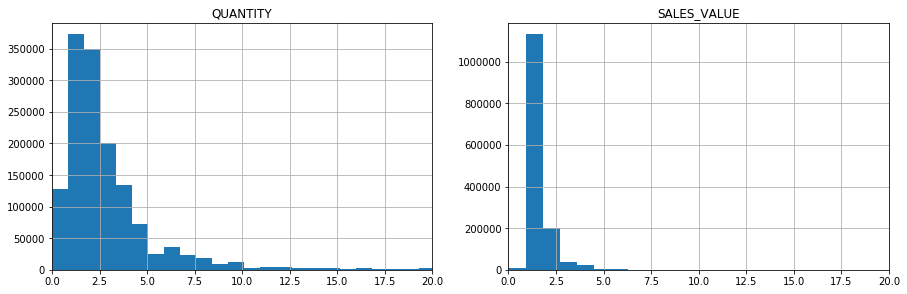

In [29]:
plt.figure(num = None, figsize = (15,10))
plt.subplot(2,2,1)
ax1 = transaction.SALES_VALUE.hist(bins=1000)
ax1.set_xlim(0,20)
plt.subplot(2,2,2)
ax2 = transaction.QUANTITY.hist(bins=100000)
ax2.set_xlim(0,20)
ax1.title.set_text('QUANTITY')
ax2.title.set_text('SALES_VALUE')
plt.show()

_**Comments:**<br>
We plot a heatmap of the correlations between the transaction features, we observe the following:_
- _Most of the high correlations we observe are expected for example between 'Day' and 'Week_No', 'Quantity' and 'Sales value'._
- _We observe a slightly high correlation between the product ID and Quantity, as well as with the sales value._

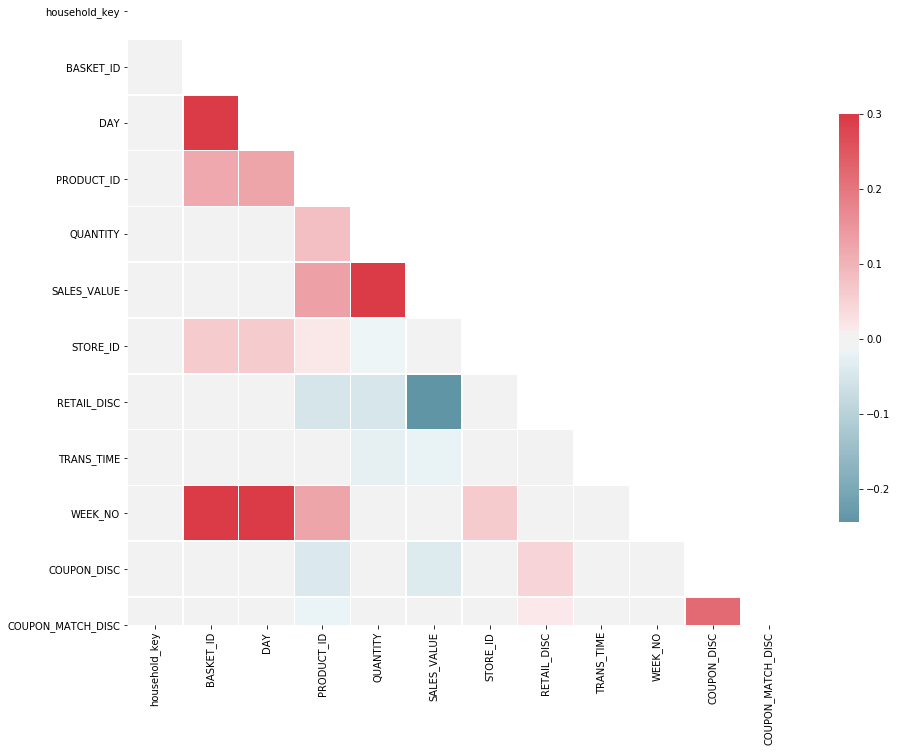

In [28]:
corr = transaction.corr(method = 'pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

#### **A3. Products Analysis:**

_**Comments:** <br>
The products subdataset contains the list of products purchased by households during the study. It gives information about each product sold as type of product,national or private label and brand identifier. The main goal of the project is to analyse people's food consumption, we limited our analysis on food related product ('list_food'). We plot the distributions of each feature, we get the following plots and observations:_
- _`DEPARTMENT` : Group similar products together, the majority of product sold where in the Grocery departement._ 
- _`BRAND` : Indicates Private or National label brand, the large majority of product sold came from national brands._ 
- _`COMMODITY_DESC` : Group similar products together at a lower level. _
- _`SUB_COMMODITY_DESC` : Group similar products together at the lowest level._

In [36]:
product = pd.read_csv('data/Dunhumby/product.csv', delimiter=',')
nRow, nCol = product.shape
print(f'There are {nRow} rows and {nCol} columns')
product.head()

There are 92353 rows and 7 columns


,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


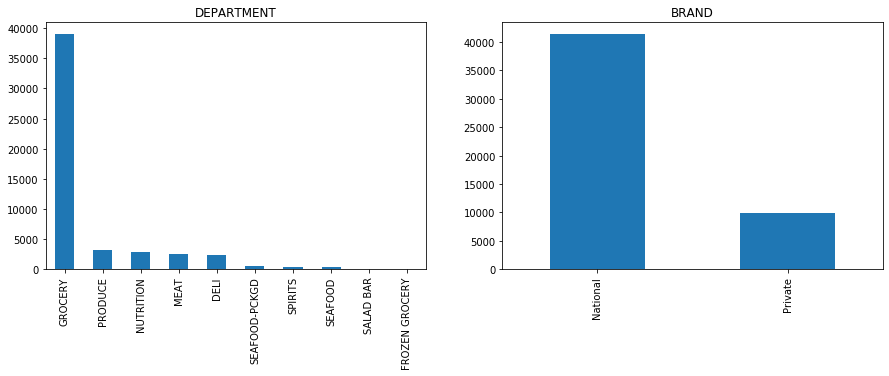

In [40]:
list_food = ['GROCERY','PASTERY','PRODUCE','NUTRITION','MEAT','FROZEN GROCERY','SALAD BAR','SEAFOOD','SPIRITS','SEAFOOD-PCKGD','MEAT-PCKG','DELI'] 
food_related_products = product[product.DEPARTMENT.apply(lambda x: x in list_food)]
plt.figure(num = None, figsize = (15,10))
plt.subplot(2,2,1)
ax1 = food_related_products.DEPARTMENT.value_counts().plot.bar()
plt.subplot(2,2,2)
ax2 = food_related_products.BRAND.value_counts().plot.bar()
ax1.title.set_text('DEPARTMENT')
ax2.title.set_text('BRAND')
plt.show()

#### **A4. Grouping the datasets:**

_**Comments:** <br>
In order to simplify the analysis of the dataset, we decided to merge them based on the Houselhold key. The new dataset contains all the features it is household centric, for each household we have the informations on the consumed product which makes the analysis  simpler._

In [41]:
food_related_products.drop(columns = ['BRAND','CURR_SIZE_OF_PRODUCT','MANUFACTURER'],inplace = True)
consumution = transaction.drop(columns = ['STORE_ID','RETAIL_DISC','TRANS_TIME','COUPON_DISC','COUPON_MATCH_DISC'])
inter = pd.merge(food_related_products,consumution,on =  'PRODUCT_ID')
full_data_set = pd.merge(inter,demographic,on = 'household_key')
full_data_set.head()

C:\Users\smail\Anaconda3\envs\ada\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PRODUCT_ID,DEPARTMENT,COMMODITY_DESC,SUB_COMMODITY_DESC,household_key,BASKET_ID,DAY,QUANTITY,SALES_VALUE,WEEK_NO,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
0,25671,GROCERY,FRZN ICE,ICE - CRUSHED/CUBED,1228,29046618323,157,1,3.49,23,45-54,Single,100-124K,Unknown,Single Female,1,None/Unknown
1,43266,GROCERY,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1228,29513525602,187,1,0.89,27,45-54,Single,100-124K,Unknown,Single Female,1,None/Unknown
2,68543,GROCERY,DOG FOODS,CAN DOGFD GOURMET/SUPER PREM (,1228,31841925002,325,1,0.69,47,45-54,Single,100-124K,Unknown,Single Female,1,None/Unknown
3,71759,GROCERY,FROZEN PIE/DESSERTS,FRZN WHIPPED TOPPING,1228,30589276083,235,1,0.69,34,45-54,Single,100-124K,Unknown,Single Female,1,None/Unknown
4,73580,GROCERY,ICE CREAM/MILK/SHERBTS,QUARTS,1228,28394445201,117,1,4.99,17,45-54,Single,100-124K,Unknown,Single Female,1,None/Unknown


_**Comments:**<br>
We plot a heatmap of the correlations between the income and total money spent during the study, we observe the following:_
- _Most of the high correlations are between high incomes and total money spent during the study ('sales_value_y') ._
- _We observe a slightly negative correlation between low incomes and total money spent during the study ('sales_value_y')._
The more money we make,the more we spend on food.

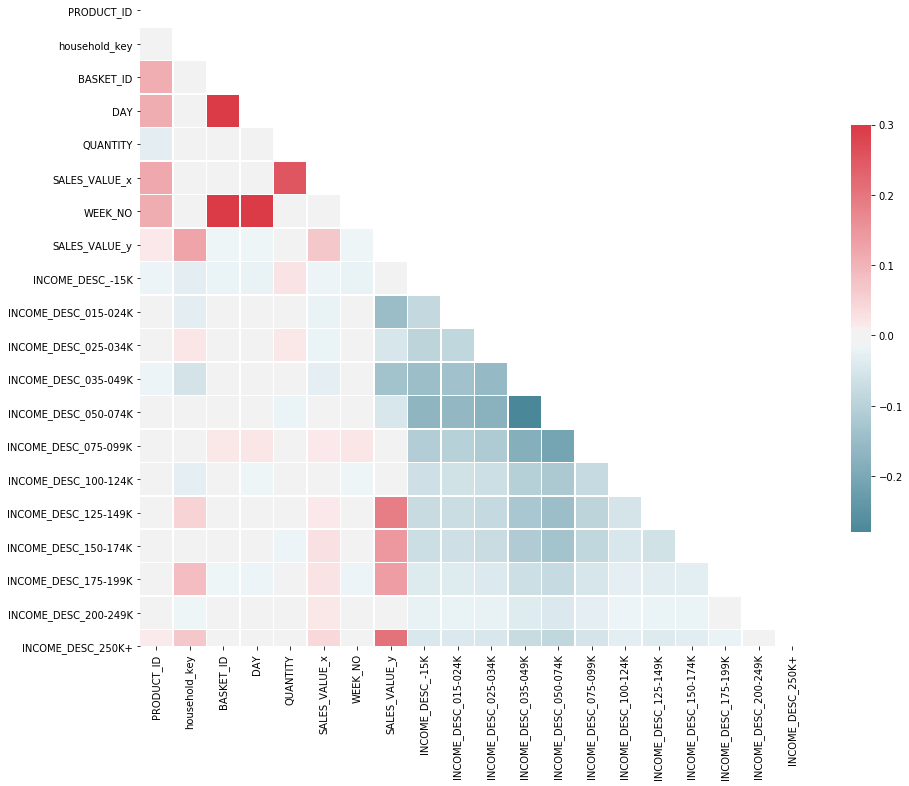

In [42]:
behavior_consummer = full_data_set.groupby(['household_key']).sum().SALES_VALUE
full_data_set_test = pd.merge(full_data_set,behavior_consummer,on = 'household_key')
zab3 = pd.get_dummies(full_data_set_test, columns=["INCOME_DESC"])
corr = zab3.corr(method = 'pearson')

corr.SALES_VALUE_y.sort_values(ascending = False)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [211]:
df = full_data_set
list_income = df.INCOME_DESC.value_counts().index
list_food = []
for i in range(len(list_income)):
    test = full_data_set[full_data_set.INCOME_DESC.apply(lambda x: x == list_income[i])]
    list_food.append(list(test.SUB_COMMODITY_DESC.value_counts()[:10].index))
count = 0
for l in list_food:
    print('the income',list_income[count])
    elements1 = []
    elements2 = []
    for element in l:
        inter = list_food.copy()
        inter.remove(l)
        list_final = [x for xs in inter for x in xs]
        if(element not in list_final or list_final.count(element) <3):
            elements1.append(element)
        else:
            elements2.append(element)
            
    print('specific food : ', elements1)
            
    count += 1
    
print('general elements :', elements2)

the income 50-74K
specific food :  ['FRZN SS PREMIUM ENTREES/DNRS/N', 'CONDENSED SOUP']
the income 35-49K
specific food :  ['KIDS CEREAL']
the income 75-99K
specific food :  ['FRZN BAGGED VEGETABLES - PLAIN', 'FRZN SS PREMIUM ENTREES/DNRS/N', 'BEERALEMALT LIQUORS']
the income 25-34K
specific food :  ['SFT DRNK SNGL SRV BTL CARB (EX', 'BEERALEMALT LIQUORS']
the income Under 15K
specific food :  ['KIDS CEREAL']
the income 15-24K
specific food :  ['KIDS CEREAL']
the income 125-149K
specific food :  ['YOGURT MULTI-PACKS', 'PREMIUM', 'SNACK CAKE - MULTI PACK']
the income 150-174K
specific food :  ['CAN CATFD GOURMET/SUP PREM (GR', 'FRZN SS PREMIUM ENTREES/DNRS/N', 'DAIRY CASE 100% PURE JUICE - O', 'PREMIUM', 'STRAWBERRIES']
the income 100-124K
specific food :  ['DAIRY CASE 100% PURE JUICE - O', 'BEERALEMALT LIQUORS', 'RTS SOUP: CHUNKY/HOMESTYLE ET']
the income 250K+
specific food :  ['RTS SOUP: CHUNKY/HOMESTYLE ET', 'PREMIUM', 'ALL FAMILY CEREAL', 'SALAD BAR FRESH FRUIT', 'CONDENSED SOUP']


In [212]:
df = full_data_set
list_income = df.AGE_DESC.value_counts().index
list_food = []
for i in range(len(list_income)):
    test = full_data_set[full_data_set.AGE_DESC.apply(lambda x: x == list_income[i])]
    list_food.append(list(test.SUB_COMMODITY_DESC.value_counts()[:10].index))
count = 0
for l in list_food:
    print('the income',list_income[count])
    elements1 = []
    elements2 = []
    for element in l:
        inter = list_food.copy()
        inter.remove(l)
        list_final = [x for xs in inter for x in xs]
        if(element not in list_final or list_final.count(element) <3):
            elements1.append(element)
        else:
            elements2.append(element)
            
    print('specific food : ', elements1)
            
    count += 1
    
print('general elements :', elements2)

the income 45-54
specific food :  ['CONDENSED SOUP', 'BEERALEMALT LIQUORS']
the income 35-44
specific food :  ['FRZN SS PREMIUM ENTREES/DNRS/N', 'CONDENSED SOUP']
the income 25-34
specific food :  ['BEERALEMALT LIQUORS', 'FRZN SS PREMIUM ENTREES/DNRS/N']
the income 65+
specific food :  ['CONDENSED SOUP', 'DAIRY CASE 100% PURE JUICE - O', 'RTS SOUP: CHUNKY/HOMESTYLE ET', 'FRZN SS PREMIUM ENTREES/DNRS/T']
the income 55-64
specific food :  ['DAIRY CASE 100% PURE JUICE - O', 'CAN CATFD GOURMET/SUP PREM (GR']
the income 19-24
specific food :  ['SS ECONOMY ENTREES/DINNERS ALL', 'KIDS CEREAL', 'RTS SOUP: CHUNKY/HOMESTYLE ET']
general elements : ['SFT DRNK 2 LITER BTL CARB INCL', 'FLUID MILK WHITE ONLY', 'SOFT DRINKS 12/18&15PK CAN CAR', 'YOGURT NOT MULTI-PACKS', 'MAINSTREAM WHITE BREAD', 'SHREDDED CHEESE', 'POTATO CHIPS']


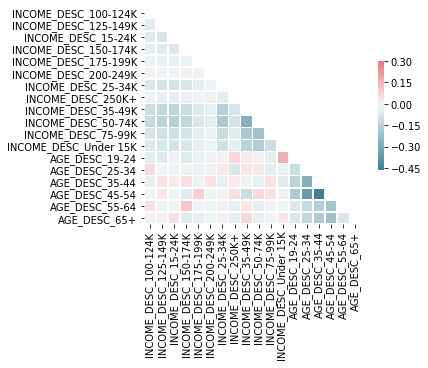

In [216]:
zab3 = pd.get_dummies(full_data_set_test.loc[:,["INCOME_DESC","AGE_DESC"]], columns=["INCOME_DESC","AGE_DESC"])
corr = zab3.corr(method = 'pearson')
import seaborn as sns
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#corr.style.background_gradient(cmap='coolwarm')
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [334]:
behavior_consummer = full_data_set.groupby('household_key')['SUB_COMMODITY_DESC'].value_counts()
behavior_consummer

household_key  SUB_COMMODITY_DESC            
1              FRUIT/BREAKFAST BREAD             53
               DAIRY CASE 100% PURE JUICE - O    45
               BANANAS                           41
               FLUID MILK WHITE ONLY             40
               PUDDINGS DRY                      37
                                                 ..
2499           TRAY PACK/CHOC CHIP COOKIES        1
               TUNA                               1
               VENDING SIZE/SNGL SERVE CRACKE     1
               WATER ICE                          1
               YOGURT NOT MULTI-PACKS             1
Name: SUB_COMMODITY_DESC, Length: 210131, dtype: int64

In [337]:
behavior_consummer[230][:5]

SUB_COMMODITY_DESC
SOFT DRINKS 12/18&15PK CAN CAR    103
FLUID MILK WHITE ONLY              61
CANNED CAT FOOD (9 LIVES/FRISK     58
SFT DRNK SNGL SRV BTL CARB (EX     55
ISOTONIC DRINKS SINGLE SERVE       45
Name: SUB_COMMODITY_DESC, dtype: int64

In [323]:
test[4]

37

In [188]:
behavior_consummer = full_data_set.groupby(['household_key','BASKET_ID']).sum().SALES_VALUE
behavior_consummer.index[0][0]
behavior_consummer
corr.style.background_gradient(cmap='coolwarm')

household_key  BASKET_ID  
1              27601281299     54.70
               27774192959     19.62
               28024266849     24.40
               28106322445     55.23
               28235481967     36.75
                               ...  
2499           41757951357      1.00
               41782556633    195.46
               42063090170     11.87
               42198526158    267.25
               42263272421      5.89
Name: SALES_VALUE, Length: 114674, dtype: float64